In [1]:
!pip install transformers
!pip install datasets
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install bert_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import numpy as np
import pandas as pd
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from transformers import BartTokenizer, BartForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset, load_metric
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
from transformers import AutoTokenizer, LongT5ForConditionalGeneration, T5ForConditionalGeneration


In [5]:
train_import = pd.read_json('/content/drive/MyDrive/NLP Project Files/Maddy/data/train.jsonl', lines = True)
test_import = pd.read_json('/content/drive/MyDrive/NLP Project Files/Maddy/data/validation.jsonl', lines = True)

train_import['tags'] = train_import['tags'].map(lambda x: x[0])
test_import['tags'] = test_import['tags'].map(lambda x: x[0])

train_import = train_import[train_import['tags'] == 'phrase']
test_import = test_import[test_import['tags'] == 'phrase']

train_import['spoiler'] = train_import['spoiler'].map(lambda x: x[0])
test_import['spoiler'] = test_import['spoiler'].map(lambda x: x[0])

<ipython-input-5-6cfabc379e98>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_import['spoiler'] = train_import['spoiler'].map(lambda x: x[0])
<ipython-input-5-6cfabc379e98>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_import['spoiler'] = test_import['spoiler'].map(lambda x: x[0])


1
11


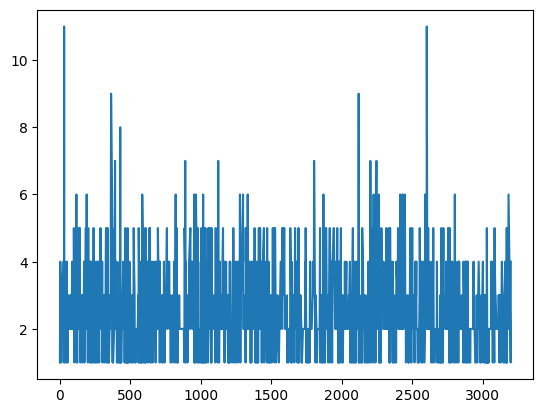

In [6]:
import matplotlib.pyplot as plt

tempo = train_import['spoiler'].apply(lambda x: len(x.split()))

plt.plot(tempo)

print(tempo.min())
print(tempo.max())

In [7]:
train_import['processedParagpraphs'] = train_import['targetParagraphs'].map(lambda x: '. '.join(x))
test_import['processedParagpraphs'] = test_import['targetParagraphs'].map(lambda x: '. '.join(x))

train_import['processedText'] = train_import['postText'].map(lambda x: x[0])
test_import['processedText'] = test_import['postText'].map(lambda x: x[0])

7
7607
308.0
843.4000000000001


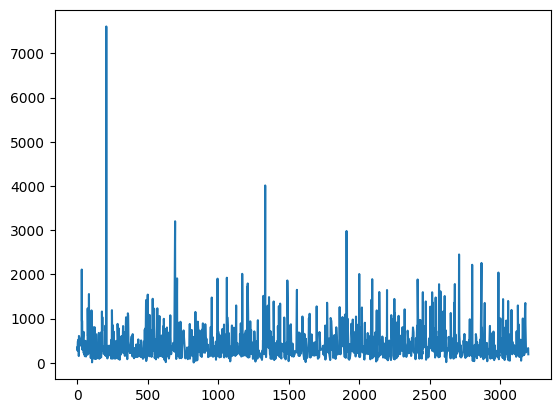

In [8]:
temp_2 = train_import['processedParagpraphs'].map(lambda x: len(x.split()))

plt.plot(temp_2)
print(temp_2.min())
print(temp_2.max())
print(temp_2.median())
print(temp_2.quantile(0.9))

In [9]:
def preprocess_data(example):
    input_text = "condition: " + example['processedText'] + " paragraph: " + example['processedParagpraphs']
    target_text = example['spoiler']
    return {"input_text": input_text, "target_text": target_text}

In [10]:
train_dataset = Dataset.from_pandas(train_import)
test_dataset = Dataset.from_pandas(test_import)

train_dataset_processed = train_dataset.map(preprocess_data)
test_dataset_processed = test_dataset.map(preprocess_data)

Map:   0%|          | 0/1367 [00:00<?, ? examples/s]

Map:   0%|          | 0/335 [00:00<?, ? examples/s]

In [11]:
model_name = "t5-base"

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length = 512)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [12]:
bleu_metric = load_metric("bleu")
meteor_metric = load_metric("meteor")
bertscore_metric = load_metric("bertscore")
bleu_4_logging = load_metric("bleu", n = 4)

<ipython-input-12-01930b8e669f>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("bleu")
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
#out_1 = []
#out_2 = []

def compute_metrics(eval_pred):
    logits_full, labels = eval_pred

    #out_1.append(logits_full[0])
    #out_2.append(logits_full[1])

    predicted_token_ids = torch.argmax(torch.tensor(logits_full[0]), dim=-1).tolist()
    decoded_preds = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds_bleu = [pred.split() for pred in decoded_preds]
    decoded_labels_bleu = [[pred.split()] for pred in decoded_labels]
    
    bleu_score = bleu_metric.compute(predictions=decoded_preds_bleu, references= decoded_labels_bleu)
    bleu_4_logger = bleu_4_logging.compute(predictions=decoded_preds_bleu, references= decoded_labels_bleu)
    meteor_score = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    bertscore_score = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang = 'en')
    
    return {"bleu": bleu_score["bleu"], "bleu_log": bleu_4_logger["bleu"] , "meteor": meteor_score["meteor"], "bertscore": np.mean(bertscore_score["f1"])}

In [14]:
def encode_data(batch):
    input_ids = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length= 512, return_tensors="pt").input_ids
    target_ids = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length= 11, return_tensors="pt").input_ids
    return {"input_ids": input_ids, "labels": target_ids}

encoded_train_dataset = train_dataset_processed.map(encode_data, batched=True)
encoded_test_dataset = test_dataset_processed.map(encode_data, batched=True)

columns_to_remove = ['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs', 'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia', 'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags', 'processedParagpraphs', 'processedText', '__index_level_0__']
encoded_train_dataset = encoded_train_dataset.remove_columns(columns_to_remove)
encoded_test_dataset = encoded_test_dataset.remove_columns(columns_to_remove)


Map:   0%|          | 0/1367 [00:00<?, ? examples/s]

Map:   0%|          | 0/335 [00:00<?, ? examples/s]

In [15]:
training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/NLP Project Files/conditional_generation/phrase/results/{model_name}_results",
    num_train_epochs=15,
    per_device_train_batch_size=4,
    per_device_eval_batch_size= 4,
    evaluation_strategy="epoch",
    logging_steps=100,
    save_steps=0,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_strategy="epoch"

)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience= 3)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

metrics = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu,Bleu Log,Meteor,Bertscore
1,0.665000,0.428727,0.500752,0.500752,0.554848,0.960344
2,0.452500,0.373720,0.524873,0.524873,0.607683,0.961004
3,0.375500,0.369878,0.535372,0.535372,0.618189,0.967272
4,0.283100,0.371358,0.540775,0.540775,0.610008,0.965085
5,0.231000,0.385046,0.550160,0.550160,0.618833,0.968424
6,0.210700,0.398168,0.526687,0.526687,0.614405,0.968170
7,0.177500,0.420022,0.546073,0.546073,0.623872,0.969488
8,0.184300,0.416404,0.545938,0.545938,0.622272,0.971005
9,0.175400,0.435766,0.549077,0.549077,0.611156,0.969575
10,0.159000,0.443484,0.550032,0.550032,0.615061,0.970588


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 30>:30                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1664 in train                    │
│                                                                                                  │
│   1661 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1662 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1663 │   │   )                                                                                 │
│ ❱ 1664 │   │   return inner_training_loop(                                                       │
│   1665 │   │   │   args=args,                                                                    │
│   1666 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1667 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1940 in _inner_training_loop     │
│                                                                                                  │
│   1937 │   │   │   │   │   with model.no_sync():                                                 │
│   1938 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1939 │   │   │   │   else:                                                                     │
│ ❱ 1940 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1941 │   │   │   │                                                                             │
│   1942 │   │   │   │   if (                                                                      │
│   1943 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2753 in training_step            │
│                                                                                                  │
│   2750 │   │   │   # loss gets scaled under gradient_accumulation_steps in deepspeed             │
│   2751 │   │   │   loss = self.deepspeed.backward(loss)                                          │
│   2752 │   │   else:                                                                             │
│ ❱ 2753 │   │   │   loss.backward()                                                               │
│   2754 │   │                                                                                     │
│   2755 │   │   return loss.detach()                                                              │
│   2756                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/_tensor.py:487 in backward                         │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_gra

In [17]:
best_model_checkpoint = trainer.state.best_model_checkpoint
print(f"Best model checkpoint: {best_model_checkpoint}")


Best model checkpoint: /content/drive/MyDrive/NLP Project Files/conditional_generation/phrase/results/t5-base_results/checkpoint-1710
